# Assignment 2
## Sentiment Classification

This assignment approaches the sentiment classification problem by using deep learning techniques and also exposes some ethical problem related to these methods.

This is what we’re going to do:

+ Acquire some pre-computed word embeddings to represent the meanings of words
+ Acquire training and test data, with gold-standard examples of positive and negative words
+ Train a simple classifier to recognize other positive and negative words based on their word embeddings
+ Compute sentiment scores for sentences of text using this classifier
+ Analyze the results to look for unwanted bias. 

## Word embeddings

There are several datasets of pre-trained English word embeddings such as `word2vec`, pretrained on Google News data, and `GloVe`, pretrained on the Common Crawl of web pages. We will use `GloVe`.

GloVe comes in three sizes: 6B, 42B, and 840B. The 42B version is pretty good and is also neatly trimmed to a vocabulary of 1 million words. We will just use the 42B version.

> **GloVe.42B** data: 42B tokens, 1.9M vocab, uncased, 300d vectors, 1.75 GB download

In [1]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2019-03-29 10:01:34--  http://nlp.stanford.edu/data/glove.42B.300d.zip
S'està resolent nlp.stanford.edu (nlp.stanford.edu)… 171.64.67.140
S'està connectant a nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80… connectat.
HTTP: s'ha enviat la petició, s'està esperant una resposta… 302 Found
Ubicació: https://nlp.stanford.edu/data/glove.42B.300d.zip [es segueix]
--2019-03-29 10:01:34--  https://nlp.stanford.edu/data/glove.42B.300d.zip
S'està connectant a nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443… connectat.
HTTP: s'ha enviat la petició, s'està esperant una resposta… 200 OK
Mida: 1877800501 (1,7G) [application/zip]
S'està desant a: «glove.42B.300d.zip»

glove.42B.300d.zip  100%[===================>]   1,75G  8,33MB/s    in 7m 14s  

2019-03-29 10:08:49 (4,13 MB/s) - s'ha desat «glove.42B.300d.zip» [1877800501/1877800501]



In [5]:
!unzip glove.42B.300d.zip

Archive:  glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def load_embeddings(filename):
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in tqdm(enumerate(infile)):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('glove.42B.300d.txt')
embeddings.shape

1917494it [02:27, 13004.81it/s]


(1917494, 300)

## Positive and Negative Words

We need some input about which words are positive and which words are negative. There are many sentiment lexicons you could use, but we’re going to go with a very straightforward lexicon from https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html  

There is a copy of these files in the GitHub repository of the course.

In [22]:
def load_lexicon(filename):
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('data/positive-words.txt')
neg_words = load_lexicon('data/negative-words.txt')

Some of these words are not in the GloVe vocabulary. Those words end up with rows full of NaN to indicate their missing embeddings, so we will use Pandas to clean the dataset.

In [23]:
pos_vectors = embeddings.loc[pos_words].dropna()
neg_vectors = embeddings.loc[neg_words].dropna()

/Users/jordivitria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/Users/jordivitria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


Now we make arrays of the desired inputs and outputs. The inputs are the embeddings, and the outputs are `1` for positive words and `-1` for negative words. We also make sure to keep track of the words they’re labeled with, so we can interpret the results.

In [24]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [25]:
from sklearn.model_selection import train_test_split

train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

Now it is time to make your classifier, and train it by running the training vectors through it for 100 iterations. You can use a logistic function as the loss, so that the resulting classifier can output the probability that a word is positive or negative.

In [1]:
# write your classifier here



Evaluate your classifier on the test vectors. Which is the classifier performace (in terms of accuracy)?

In [2]:
# Compute your classifier accuracy
# It should predict the correct sentiment for sentiment words outside of its training data 95% of the time.



Let’s define a function that we can use to see the sentiment that this classifier predicts for particular words, then use it to see some examples of its predictions on the test data.

In [28]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).ix[:20]

/Users/jordivitria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,sentiment
fidget,-9.931679
interrupt,-9.634706
staunchly,1.466919
imaginary,-2.989215
taxing,0.468522
world-famous,6.908561
low-cost,9.237223
disapointment,-8.737182
totalitarian,-10.851580
bellicose,-8.328674


## Sentiment score for text

There are many ways to combine sentiments for word vectors into an overall sentiment score. The simplest way is to average them.

In [29]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean()

In [30]:
text_to_sentiment("this example is pretty cool")

3.889968926086297

In [31]:
text_to_sentiment("meh, this example sucks")

-1.1774475917460707

Let’s see what it does with a few variations on a neutral sentence:

In [32]:
print(text_to_sentiment("Let's go get Italian food"))
print(text_to_sentiment("Let's go get Chinese food"))
print(text_to_sentiment("Let's go get Mexican food"))

2.0429166109408996
1.409403365814098
0.38801985560121777


In [33]:
print(text_to_sentiment("My name is Emily"))
print(text_to_sentiment("My name is Heather"))
print(text_to_sentiment("My name is Yvette"))
print(text_to_sentiment("My name is Shaniqua"))


2.2286179364745284
1.397629115107915
0.9846380213298535
-0.4704813177589089


The system has associated wildly different sentiments with people’s names. You can look at these examples and many others and see that the sentiment is generally more positive for stereotypically-white names, and more negative for stereotypically-black names.

## Ethical problem

We want to learn how to not make something like this again. So let’s put more data through it, and statistically measure how bad its bias is.

Here we have four lists of names that tend to reflect different ethnic backgrounds, mostly from a United States perspective. The first two are lists of predominantly “white” and “black” names adapted from Caliskan et al.’s article. I also added typically Hispanic names, as well as Muslim names that come from Arabic or Urdu; these are two more distinct groupings of given names that tend to represent your background.

In [34]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Ayaan', 'Syed', 'Rishaan', 'Samar', 'Ahmad', 'Zikri', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin'
    ]
}

Now we’ll use Pandas to make a table of these names, their predominant ethnic background, and the sentiment score we get for them:

In [35]:
def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

name_sentiments = name_sentiment_table()

name_sentiments.ix[::25]

/Users/jordivitria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/Users/jordivitria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/Users/jordivitria/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documenta

,sentiment,group
mohammed,0.834974,Arab/Muslim
alya,3.916803,Arab/Muslim
terryl,-2.858010,Black
josé,0.432956,Hispanic
luciana,1.086073,Hispanic
hank,0.391858,White
megan,2.158679,White


(-10, 10)

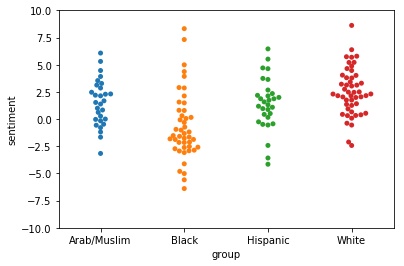

In [36]:
plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
plot.set_ylim([-10, 10])

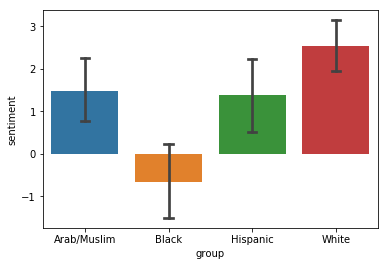

In [37]:
plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)